# Starbucks : LDA, QDA, NB
## Configuration

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

## Import des données

In [14]:
starbucks = pd.read_csv("D:/UTC/SY09/Projet/tests locaux/clean_starbucks.csv")
starbucksX = starbucks.drop(columns=["product_name", "milk", "size", "whip", "serv_size_m_l", "Category"])
starbucksZ = starbucks.Category

## Calculs d'erreurs par validation croisée

In [15]:
plis = 10

models = [
    (LinearDiscriminantAnalysis, "LDA"),
    (QuadraticDiscriminantAnalysis, "QDA"),
    (GaussianNB, "NB"),
]

LDA = LinearDiscriminantAnalysis()
QDA = QuadraticDiscriminantAnalysis()
GNB = GaussianNB()

def validation_errors(X, Z, models):
    for model, name in models:
        for acc in cross_val_score(model(), X, Z, cv=10):
            yield name, acc

## Sélection d'un modèle à partir de plusieurs *seeds*

In [91]:
def choose_LDA_model(X, Z, seeds):
    for i in seeds:
        X_train, X_test, z_train, z_test = train_test_split(X, Z, test_size=0.33, random_state=i)
    
        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, z_train)

        z_pred = lda.predict(X_test)

        z_comp = pd.DataFrame({"Prediction": z_pred, "Realite": z_test})

        z_failed = z_comp.loc[z_comp["Prediction"] != z_comp["Realite"]]
        
        yield i, accuracy_score(z_pred, z_test), len(z_failed)
        
def choose_QDA_model(X, Z, seeds):
    for i in seeds:
        X_train, X_test, z_train, z_test = train_test_split(X, Z, test_size=0.33, random_state=i)
    
        qda = QuadraticDiscriminantAnalysis()
        qda.fit(X_train, z_train)

        z_pred = lda.predict(X_test)

        z_comp = pd.DataFrame({"Prediction": z_pred, "Realite": z_test})

        z_failed = z_comp.loc[z_comp["Prediction"] != z_comp["Realite"]]
        
        yield i, accuracy_score(z_pred, z_test), len(z_failed)

## Matrice de confusion

In [89]:
def confusion_matrix(z_pred, z_test):
    z_comp = pd.DataFrame({"Prediction": z_pred, "Realite": z_test})
    res = {}
    
    for i in z_test.unique() : # attendu
        values = []
        for j in z_test.unique(): # predit
            values.append(100 * len(z_comp[ (z_comp["Realite"]==i) & (z_comp["Prediction"]==j)]) / len(z_comp[z_comp["Realite"]==i]))
        res[i] = values
        
    conf = pd.DataFrame(res)
    indexes = []
    for i in conf.columns:
        indexes.append(i + "_pred")
    conf.index = indexes
    return conf

## Essai sur toutes les catégories
### Validation croisée

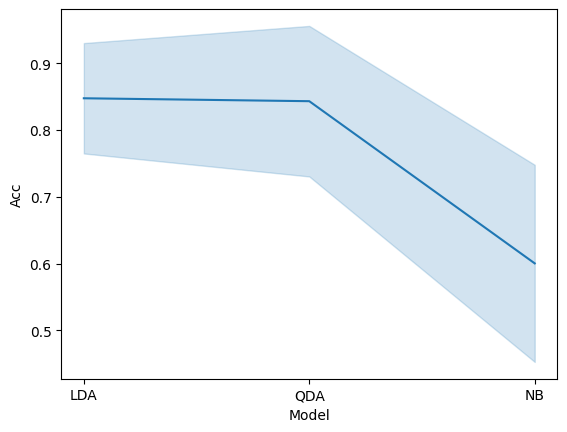

In [105]:
cv_err_X1 = pd.DataFrame(validation_errors(starbucksX, starbucksZ, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=cv_err_X1, errorbar="sd")
plt.show()

La LDA paraît intéressante, avec globalement moins d'erreurs que la QDA. Le NB semble à éviter (on sait par ailleurs que son hypothèse d'indépendance des variables est mauvaise dans notre cas).

### Sélection d'un modèle LDA

In [41]:
accuracy_max = cv_err_X1[cv_err_X1["Model"]=="LDA"]["Acc"].max()

print("L'accuracy maximale trouvée par cross_validation est : ", accuracy_max)

seeds = pd.DataFrame(choose_LDA_model(starbucksX, starbucksZ, range(9200,9300)), columns=["Seed", "Accuracy", "Failed"])

seed_max = seeds.groupby("Seed").mean().Accuracy.idxmax()

print("La meilleure seed est : ", seed_max, " d'une accuracy ", seeds[seeds["Seed"]==seed_max]["Accuracy"].mean(), " soit ", seeds[seeds["Seed"]==seed_max]["Failed"].mean(), " erreurs d'affectation.")

L'accuracy maximale trouvée par cross_validation est :  0.956140350877193
La meilleure seed est :  9229  d'une accuracy  0.9313984168865436  soit  26.0  erreurs d'affectation.


On pourrait trouver mieux, mais de 0 à 10000, c'est 9229 qui a le meilleur score d'accuracy.
On peut générer et étudier le modèle.

In [90]:
X_train, X_test, z_train, z_test = train_test_split(starbucksX, starbucksZ, test_size=0.33, random_state=9229)
    
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, z_train)

z_pred = lda.predict(X_test)

conf = confusion_matrix(z_pred, z_test)
conf

,coffee,frappuccino,tea,other,chocolate
coffee_pred,94.444444,0.000000,8.450704,0.000000,0.0
frappuccino_pred,3.703704,99.074074,0.000000,7.692308,0.0
tea_pred,1.851852,0.000000,91.549296,30.769231,20.0
other_pred,0.000000,0.000000,0.000000,61.538462,0.0
chocolate_pred,0.000000,0.925926,0.000000,0.000000,80.0


### Sélection d'un modèle QDA

In [102]:
accuracy_max = cv_err_X1[cv_err_X1["Model"]=="QDA"]["Acc"].max()

print("L'accuracy maximale trouvée par cross_validation est : ", accuracy_max)

seeds = pd.DataFrame(choose_QDA_model(starbucksX, starbucksZ, range(8900,9000)), columns=["Seed", "Accuracy", "Failed"])

seed_max = seeds.groupby("Seed").mean().Accuracy.idxmax()

print("La meilleure seed est : ", seed_max, " d'une accuracy ", seeds[seeds["Seed"]==seed_max]["Accuracy"].mean(), " soit ", seeds[seeds["Seed"]==seed_max]["Failed"].mean(), " erreurs d'affectation.")

L'accuracy maximale trouvée par cross_validation est :  0.9912280701754386
La meilleure seed est :  8972  d'une accuracy  0.9313984168865436  soit  26.0  erreurs d'affectation.


On pourrait trouver mieux, mais de 0 à 10000, c'est 8972 qui a le meilleur score d'accuracy. On peut générer et étudier le modèle.

In [104]:
X_train, X_test, z_train, z_test = train_test_split(starbucksX, starbucksZ, test_size=0.33, random_state=8972)
    
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, z_train)

z_pred = qda.predict(X_test)

conf = confusion_matrix(z_pred, z_test)
conf

,frappuccino,coffee,tea,chocolate,other
frappuccino_pred,97.413793,5.000,0.000000,0.000000,0.000000
coffee_pred,2.586207,85.625,9.523810,3.448276,9.090909
tea_pred,0.000000,9.375,88.888889,0.000000,18.181818
chocolate_pred,0.000000,0.000,0.000000,96.551724,0.000000
other_pred,0.000000,0.000,1.587302,0.000000,72.727273


## Essai en enlevant la catégorie *other*

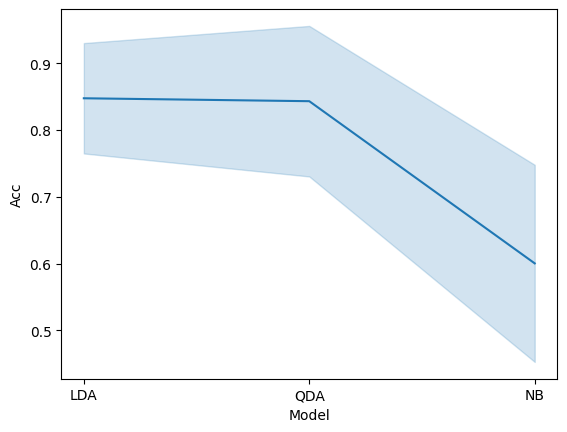

In [106]:
starbucks2 = starbucks[~starbucks["Category"].isin(["other"])]
starbucksX2 = starbucks.drop(columns=["product_name", "milk", "size", "whip", "serv_size_m_l", "Category"])
starbucksZ2 = starbucks.Category

cv_err_X2 = pd.DataFrame(validation_errors(starbucksX2, starbucksZ2, models), columns=["Model", "Acc"])
sns.lineplot(x="Model", y="Acc", data=cv_err_X2, errorbar="sd")
plt.show()

On a sensiblement la même chose